In [1]:
#some style formatting
from IPython.display import HTML
style = '''<style>
div.abstract_
text {text-align: justify;text-justify: inter-word;}
div.text {text-align: justify; text-justify: inter-word;}
</style>'''
HTML(style)


<img typeof="foaf:Image" src="static/ANTI-INFECTIVES-RGB_200pc.png" alt="Wellcome Centre for Anti-Infectives Research" title="">

# ML Analysis for <i>T. brucei</i>

Michele Tinti and Michael A.J. Ferguson

Wellcome Centre for Anti-Infectives Research
School of Life Sciences, University of Dundee
   
## Motivation
<span>
<div class=text>
To provide a usage example for our ML dataset, we tried to identify descriptors able to discriminate between proteins with long or short half-lives. It is essential to remark that our main interest is not in creating a half-life predictor, as we know the ground truth of this variable for the majority of BSF and PCF proteome. Instead, we are interested in finding if any of the descriptors incorporated in the ML dataset can shed light into the stability of the T. brucei proteome, similarly as if we were to carry out a GO term enrichment analysis using the short/long halfe-life gene sets.  
</div> 

In [2]:
#set up code
%load_ext autoreload
%autoreload 2

In [3]:
from mylib import scripts
%run mylib/scripts.py

__RANDOM_SEED = 1976
np.random.seed =__RANDOM_SEED

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.


In [4]:
import pandas as pd
#load the dataset
#final_df = pd.read_csv('indata/GenesByTaxon_Summary_43.zip',sep='\t')
tryp_df = pd.read_csv(os.path.join('input','GenesByTaxon_Summary_45.zip'), sep='\t')
#just to store the gene description
tryp_df = tryp_df[['Gene ID','Product Description']]
print(tryp_df.shape)
tryp_df.head()

(11832, 2)


,Gene ID,Product Description
0,Tb04.24M18.150,"hypothetical protein, conserved"
1,Tb04.3I12.100,hypothetical protein
2,Tb05.30F7.410,hypothetical protein
3,Tb05.5K5.10,"conserved hypothetical protein, conserved (fra..."
4,Tb05.5K5.100,"hypothetical protein, conserved"


In [5]:
ml_df=pd.read_csv(os.path.join('output', 'final_df.csv.gz'),index_col=[0])
ml_df.head()

,Gene ID,PCF_vs_BSF_pro,PCF_vs_BSFss_pro,CellCycle_min_max,CellCycle_max,CellCycle_min,Abundance_BSF_pro,Abundance_PCF_pro,Apparent_vs_Computed_MW,Pro_in_complex,...,PF_ofer_w8: D Entropy,PF_ofer_w8: F Entropy,PF_ofer_w8: G Entropy,PF_ofer_w8: K Entropy,PF_ofer_w8: M Entropy,PF_ofer_w8: N Entropy,PF_ofer_w8: Total Entropy,PF_polarizability aaScale - Window size:17 Average-Trimmed MAX,PF_polarizability aaScale - Window size:17 MAXIMUM,PF_polarizability aaScale - Window size:7 MAXIMUM
0,Tb04.24M18.150,0.402848,NaN,0.000000,0.5,0.5,5.870638,7.631146,229.805300,-1.0,...,2.880418,2.385654,3.339850,2.754888,3.432959,3.252387,2.844283,0.143641,0.170043,0.184429
1,Tb04.3I12.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-1.0,...,4.653442,1.405515,2.990477,2.846087,3.916477,2.916477,2.618204,0.173773,0.199140,0.200857
2,Tb05.30F7.410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-1.0,...,3.313417,3.152952,2.645992,2.493989,3.593525,3.152952,2.916539,0.141305,0.163202,0.169000
3,Tb05.5K5.10,NaN,NaN,NaN,NaN,NaN,7.606765,7.829130,0.000000,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Tb05.5K5.100,NaN,NaN,0.263034,11.0,10.0,6.758570,7.772564,20.888992,-1.0,...,3.008562,2.941448,3.493989,2.645992,3.008562,2.313417,2.864546,0.137756,0.165388,0.176571


## Modelling of protein half-life

In our recent paper (Tinti, Guther et al. 2019) we used SILAC based mass spectrometry analysis to reveal the synthesis and degradation profiles for thousands of proteins in the bloodstream and procyclic forms of T. brucei. From this dataset we defined a group of stable(long hal-life) and unstable (short hal-life) proteins in the BSF life stage. In particular, We divided the BSF protein half-lives into decile bins, from the less stable to the more stable protein. We then selected 837 proteins (fast half-life) from the first two half-life bins (first and second decile) and 837 protein (long half-life) from the last two half-life bins (ninth and tenth) as the training set for ML analysis. 

In [6]:
turnover_bsf = pd.read_csv(os.path.join('input','turnover','Table_S2.zip'), 
                           index_col=[0], dtype={'bins':str})
turnover_bsf = turnover_bsf[turnover_bsf['used_for_analysis']==1]
#print('bin','size')
#print(turnover_bsf['bins'].value_counts())
fast = list(turnover_bsf[(turnover_bsf['bins']=='1') | (turnover_bsf['bins']=='2')].index.values) #| (turnover_bsf['bins']=='2.0')].index.values
slow = list(turnover_bsf[(turnover_bsf['bins']=='10') | (turnover_bsf['bins']=='9') ].index.values)# | (turnover_bsf['bins']=='10.0')].index.values
print('Fast:',len(fast),'Slow:',len(slow))
target_dict ={}
for n in fast:
    target_dict[n]=1
for n in slow:
    target_dict[n]=0

Fast: 837 Slow: 837


In [7]:
ml_df['target']=[target_dict.get(n,np.nan) for n in ml_df['Gene ID']]

In [8]:
#ml_df = ml_df[ml_df.isna().sum(axis=1)<8]
#ml_df = pd.concat([ml_df.sort_values('target').tail(538),
#                   ml_df.sort_values('target').head(538)])
#ml_df['target'].value_counts()

In [9]:
X = ml_df.dropna(subset=['target'])
X.head()

,Gene ID,PCF_vs_BSF_pro,PCF_vs_BSFss_pro,CellCycle_min_max,CellCycle_max,CellCycle_min,Abundance_BSF_pro,Abundance_PCF_pro,Apparent_vs_Computed_MW,Pro_in_complex,...,PF_ofer_w8: F Entropy,PF_ofer_w8: G Entropy,PF_ofer_w8: K Entropy,PF_ofer_w8: M Entropy,PF_ofer_w8: N Entropy,PF_ofer_w8: Total Entropy,PF_polarizability aaScale - Window size:17 Average-Trimmed MAX,PF_polarizability aaScale - Window size:17 MAXIMUM,PF_polarizability aaScale - Window size:7 MAXIMUM,target
16,Tb05.5K5.210,-1.994036,NaN,NaN,NaN,NaN,8.097232,NaN,0.000000,-1.0,...,2.757094,3.121368,3.300918,3.003532,2.698677,2.923863,0.135305,0.163401,0.173857,1.0
123,Tb09.v4.0015,NaN,NaN,0.263034,8.0,0.5,7.749779,6.103549,165.901100,-1.0,...,2.813587,2.728698,3.214125,3.050626,2.857981,2.799830,0.134870,0.164299,0.166429,1.0
627,Tb11.02.5070b,NaN,NaN,0.137504,3.0,0.5,7.300305,7.716082,129.376070,-1.0,...,2.758611,3.055592,2.936948,2.827323,2.975422,2.918737,0.141482,0.169737,0.173571,1.0
908,Tb11.v5.0154,NaN,NaN,0.000000,0.5,0.5,7.911051,7.178399,46.476665,-1.0,...,3.199156,3.257259,3.004140,2.803227,2.665724,2.941697,0.143002,0.164262,0.175571,0.0
945,Tb11.v5.0191,NaN,NaN,0.263034,0.5,3.0,6.970981,6.841282,90.802986,-1.0,...,2.376376,3.047068,2.961338,3.452325,2.574315,2.913004,0.148845,0.179181,0.187571,1.0


In [10]:
X=X.dropna(axis=0, how='all')
X=X.dropna(axis=1, how='all')

### Creating the actual dataset

In [11]:
y=X['target']
del X['target']
del X['Gene ID']
del  X['Prot_Coding']
print(X.shape,y.shape)
y.value_counts()

(1674, 1112) (1674,)


0.0    837
1.0    837
Name: target, dtype: int64

When the number of descriptors (columns of the dataset) is similar or exceed the number of training instances (rows in the dataset), ML algorithms are prone to overfitting, i.e. learning associations with the response variable (fast or long half-lives) originating just by chance [12]. Intending to reduce the number of descriptors, we eliminated 277 features that correlate to other features with a Pearson correlation coefficient of 0.75 or higher. We 

In [12]:
# very crude removal of high correlated features
# Create correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
print('Removing:',len(to_drop), 'features')

Removing: 239 features


In [13]:
print(X.shape)
X=X.drop(to_drop, axis=1)
print(X.shape)

(1674, 1112)
(1674, 873)


In [14]:
#[ n for n in X.columns if 'Abundance' in n]

### Imput missing values

We imputed missing values in the categorical variables with a fake -1 class. On the other hand, the missing values of continue variables where replaced by the variable means. 

In [15]:
#Strategy to input missing values / optional but usefull for 
#visualization of the feature importance
X = scripts.input_missing_values(X, X.columns)

### First Train

We then trained a random forest algorithm implemented in LightGBM [33] to discriminate between proteins with fast or slow half-lives. Before training, we removed 35% of the training instances (blind) to evaluate the training progression on a subset of instances never seen by the predictor. The LightGBM algorithm was trained with a three-fold cross-validation (CV) strategy. With this strategy, the input data is divided into 3 subsets (also known as folds). Afterwards, The ML algorithm is trained on all but one of the subsets and evaluated on the subset that was not used for training. The process repeats 3 times, with a different subset reserved for evaluation (and excluded from training) each time. In this way, all the data is used once for both training and evaluation. The LightGBM algorithm starts the training with just one tree in the random forest and evaluates the prediction performance using the evaluation subset. With an iterative process, the algorithm adds one tree to the random forest and evaluates the prediction performance again. This process continues until the addition of a tree to the random forest model does not improve the prediction performance (early stopping). At each step, The LightGBM algorithm evaluates the prediction performance using the receiver operating characteristic curve (ROC) area under the curve (AUC) score (mean 0.75). 

In [16]:
#??run_lgb

DataSet size
X_train: (1088, 873) X_test: (586, 873) y_train: (1088,) y_test (586,) 
 1.0    293
0.0    293
Name: target, dtype: int64


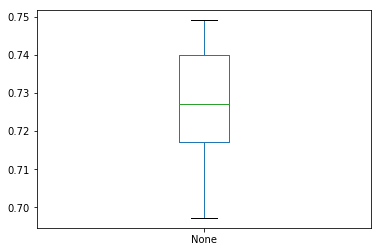

              precision    recall  f1-score   support

         0.0       0.69      0.72      0.70       279
         1.0       0.73      0.70      0.72       307

    accuracy                           0.71       586
   macro avg       0.71      0.71      0.71       586
weighted avg       0.71      0.71      0.71       586

1 dummy_roc_auc_score: 0.49486115171002637
1 blind_roc_auc_score: 0.7103779202129522

Confusion Matrix
[[201  78]
 [ 92 215]]


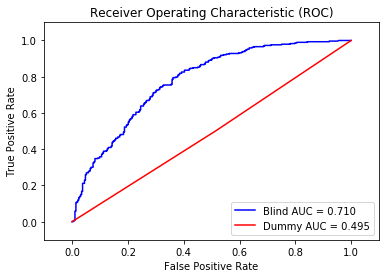

{'objective': 'binary',
 'min_data_in_leaf': 5,
 'n_jobs': 8,
 'boosting_type': 'rf',
 'bagging_fraction': 0.7,
 'feature_fraction': 0.7,
 'bagging_freq': 1,
 'n_estimators': 14,
 'max_depth': 5}

In [17]:
params = {
            'objective': 'binary',
            'min_data_in_leaf':5,
            'n_jobs':8,
            'boosting_type':"rf",
            'bagging_fraction':0.7,
            'feature_fraction':0.7,
            'bagging_freq' : 1,
            'n_estimators' : 100,
            'max_depth' : 5
            }

fitted_model, params, blind_score = scripts.run_lgb(X, y, params, random_state =__RANDOM_SEED)
params

At the end of the CV strategy, a new model is trained with all the data used for the CV step and evaluated on the blind dataset (AUC = 0.679). The blind ROC AUC score suggested that the algorithm is separating proteins with fast and long half-lives better than random.  The number of trees to evaluate the model on the blind dataset was chosen from the CV strategy. At each CV round, the algorithm records the number of trees used.  By inspecting the training history, we selected 14 trees equal to the maximum number of trees used in any of the three CV steps. This optimised model, respect to the number of tree in the forest, was used to shrink further the number of relevant features. 

### Feature Selection
#### Boruta
We first applied the Boruta methods [34] to identify all the features carrying information usable for prediction (82). Briefly, the Boruta algorithm randomises all descriptors in the dataset and evaluates the randomise features, looking if they are less or more important of the real features in separating fast and slow turnover protein. If the real features are better than the shuffled copies, they are marked as important.

In [18]:
#scripts.boruta_select??

In [19]:
print('boruta will take some times to run')
rf_params = {'class_weight':'balanced',
             'max_depth':params['max_depth'],
             'n_jobs':8, 'n_estimators':params['n_estimators'],
             'min_samples_leaf':params['min_data_in_leaf']
            }

#X.fillna(X.mean()).replace(-np.inf,-999).replace(np.inf,999)
X_train_temp, _, y_train_temp, _ = train_test_split(
    X, y, test_size=0.35, random_state =__RANDOM_SEED, stratify=y)

score_df = scripts.boruta_select(
    X_train_temp, y_train_temp, rf_params)
selected_features = list(score_df[score_df['support']]['f'])
print(len(selected_features))

boruta will take some times to run
52


In [20]:
#from mylib import make_roc_cv

second round
DataSet size
X_train: (1088, 52) X_test: (586, 52) y_train: (1088,) y_test (586,) 
 1.0    293
0.0    293
Name: target, dtype: int64


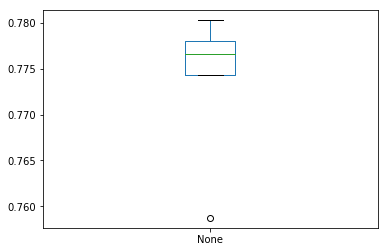

              precision    recall  f1-score   support

         0.0       0.72      0.75      0.73       281
         1.0       0.76      0.73      0.74       305

    accuracy                           0.74       586
   macro avg       0.74      0.74      0.74       586
weighted avg       0.74      0.74      0.74       586

1 dummy_roc_auc_score: 0.5
1 blind_roc_auc_score: 0.7375999066565546

Confusion Matrix
[[210  71]
 [ 83 222]]


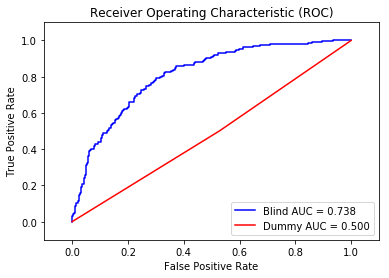

In [21]:
#second round
print('second round')
fitted_model, params , blind_score= scripts.run_lgb(X[selected_features], y, params,
                                                    random_state =__RANDOM_SEED)

#### ELI5
In a further step feature selection, we applied a different permutation importance strategy implemented in the ELI5 python package [35]. In this case, only one feature at a time is randomised, and the performance of the model evaluated. If the performance of the model decreases after randomisation (lower AUC score), the feature is annotated as important. The randomization process was performed three times with a different random seed and the average feature score difference stored. As the ELI5 strategy is more computationally expensive than the Boruta algorithm, the former was executed before the latter. 

In [22]:
#ELI5 f selection
print('ELI5 will take some times to run')

score_df = scripts.eli_select(X_train_temp[selected_features], y_train_temp, params)

ELI5 will take some times to run


In [23]:
#ELI5 df

score_df.to_csv('fimp_'+str(__RANDOM_SEED)+'.csv')
score_df.sort_values('fimp',ascending=False).head(15)

,fimp,f
0,0.088419,PCF_vs_BSF_pro
4,0.058732,Abundance_BSF_pro
3,0.038235,CellCycle_min
8,0.036305,Glucose_LSf_vs_SSs
9,0.019945,Glucose_SSf_vs_SSs
7,0.015349,BSF_to_PCF_ma1_max_min
48,0.013143,PF_ofer14: Mirror K-mer : DD
39,0.012592,PF_hp2: AAAAC
1,0.011581,CellCycle_min_max
22,0.011489,PF_Disorder_3: Mirror K-mer : AACAC


In [24]:
#score_df.sort_values('fimp',ascending=False).head(15)

final round
DataSet size
X_train: (1088, 4) X_test: (586, 4) y_train: (1088,) y_test (586,) 
 1.0    293
0.0    293
Name: target, dtype: int64


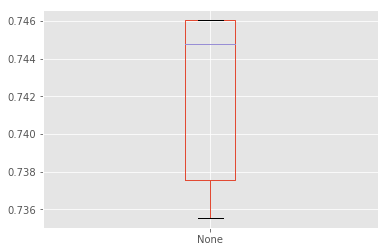

              precision    recall  f1-score   support

         0.0       0.64      0.73      0.68       258
         1.0       0.76      0.68      0.72       328

    accuracy                           0.70       586
   macro avg       0.70      0.70      0.70       586
weighted avg       0.71      0.70      0.70       586

1 dummy_roc_auc_score: 0.48450008816787166
1 blind_roc_auc_score: 0.7042801096615617

Confusion Matrix
[[188  70]
 [105 223]]


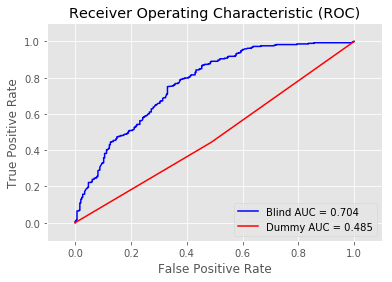

In [77]:
selected_features = list(score_df[score_df['fimp']>0.02]['f'])
#selected_features = selected_features+['CellCycle_min_max','CellCycle_max']
#final round
print('final round')
fitted_model, params, blind_score = scripts.run_lgb(X[selected_features],y, params,
                                                    random_state =__RANDOM_SEED)    

From the ELI5 ranked list of feature, we selected an arbitrary threshold of 0.015 (increase in ROC AUC score ) to select the 5 descriptors, namely: 1) 'EF_Abundance_BSF', the relative protein abundance in the BSF life stage; 2) 'EF_CellCycle_min', the time point showing the minimum protein abundance during the PCF cell cycle; 3) 'EF_fc_glucose_1', the log 2 fold change in abundance between glucose fed and glucose starve SS BSF cells; 4) 'EF_merged_PCF_BSF, the log 2 fold change of the PCF versus the BSF protein abundance, 5) 'EF_CellCycle_min_max', the log2 fold change between the minimum and maximum protein abundance value during the PCF cell cycle. We than retrained the classifier with the identified features to evaluate the performance on the blind dataset with the ROC AUC value. 

#### Different random splits
For 100 times, we split the train and test with a different random seed, we train a lgb classifier and we compute the ROC auc scores

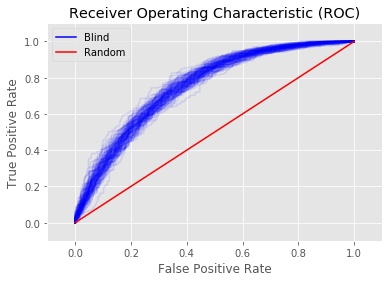

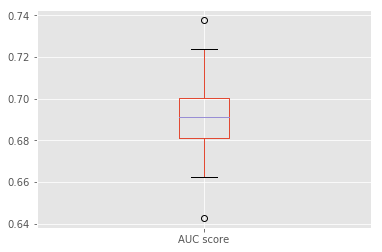

In [95]:
scripts.run_lgb_recursive(X[selected_features], y, params, 
                          0.35, np.random.randint(low=1, high=50000, size=100))

In [96]:
len(selected_features), selected_features

(4,
 ['PCF_vs_BSF_pro',
  'CellCycle_min',
  'Abundance_BSF_pro',
  'Glucose_LSf_vs_SSs'])

### Feature Importance

The importance of these selected features was visualised with the SHAP (SHapley Additive exPlanations) values. The SHAP values aggregate five different rank feature methods into one, by using an algorithm first developed for game theory. This algorithm aims at explaining the prediction of an instance (protein) by computing the contribution of each feature to the prediction. In particular, this framework assigns to each protein a SHAP value (positive for fast half-lives, negative for long half-lives), and the absolute sum of the SHAP values adds to the feature importance. Consequently, the visualization of the feature importance can be visualised along with the feature effect.(https://github.com/slundberg/shap).

In [97]:
#Now we use the SHAP scoring system to visualise 
#the most important features for the model
explainer = shap.TreeExplainer(fitted_model)
shap_values = explainer.shap_values(X[selected_features])
#shap.summary_plot(shap_values, 
                  #train[train_features],
                  #max_display=100)

In [98]:
#shap.summary_plot??

In [100]:
#shap.summary_plot(shap_values[1], X[selected_features], plot_type='dot')

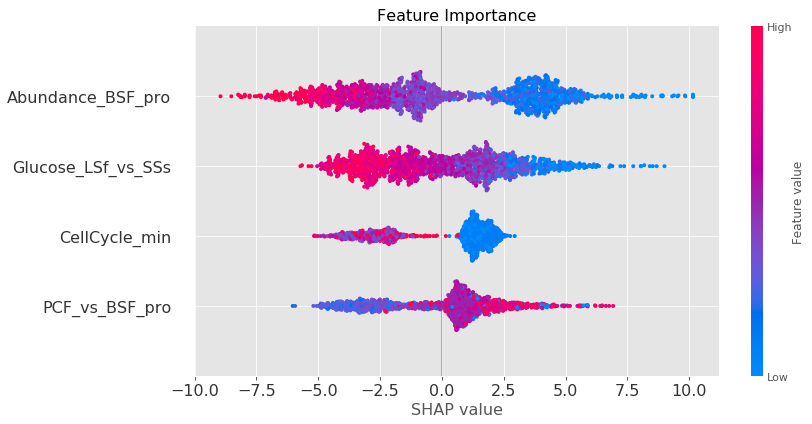

In [101]:
plt.style.use('ggplot')
shap.summary_plot(shap_values[1], 
                  X[selected_features], 
                  feature_names=troncate_name(list(X[selected_features].columns)),
                  max_display=10,show=False)

f = plt.gcf()
f.set_size_inches(12,6)
plt.title('Feature Importance',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('SHAP value',fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join('figures','example_1','Fig_1.png'))
plt.savefig(os.path.join('figures','example_1','Fig_1.svg'))
plt.savefig(os.path.join('figures','example_1','Fig_1.eps'), format='eps')
plt.show()
#print(r)

In this figure the position of the feature on the y-axis of is determined by the feature importance, and the dots (protein/training instances) on the x-axis are arranged accordingly to the SHAP values. The dots are also jittered in the y-axis direction to assess the distribution. The colour code of the dots reflects the value of the feature from low (blue) to high (red). This visualization highlights the relationship between the value of a feature and the impact on the prediction. For example, training instances with low values of the protein abundance in the BSF life stage ('EF_Abundance_BSF') have the highest SHAP values, meaning that low protein abundance values are pushing the model towards a fast half-life prediction.

### Feature Analysis

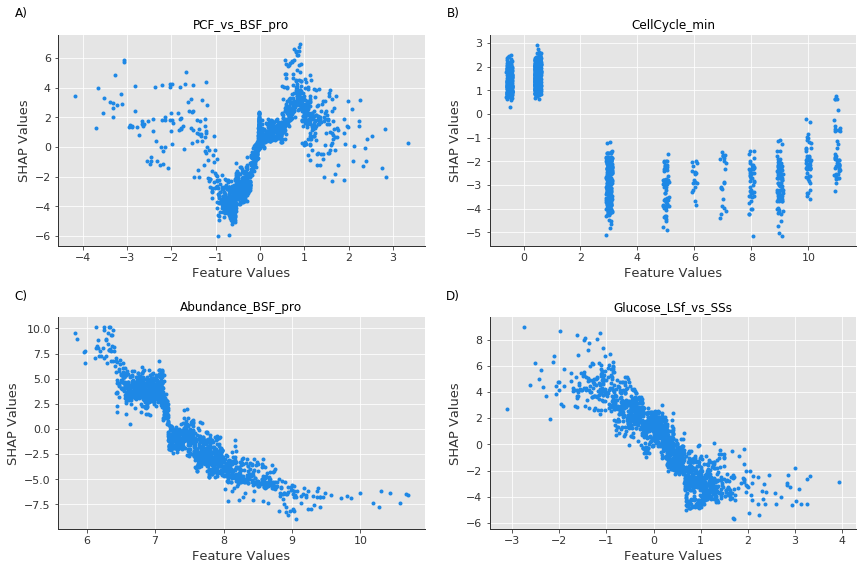

In [102]:
fig,axes = plt.subplots(figsize=(12,8), nrows=2,ncols=2)
labels = ['A','B','C','D','E','F','G']

mapping_dict = {
    0:[0,0],
    1:[0,1],
    2:[1,0],
    3:[1,1],    
    4:[2,0],
    5:[2,1], 
    6:[3,0],
               }

for n, f in enumerate(selected_features):
    a,b=mapping_dict[n][0],mapping_dict[n][1]
    if f == 'CellCycle_min':
        shap.dependence_plot(n, shap_values[1], 
                    X[selected_features],
                             interaction_index =None, 
                             x_jitter=0.2,
                             show=False,ax=axes[a][b])
    


    
    else:
        shap.dependence_plot(n, shap_values[1], 
                    X[selected_features],
                            interaction_index =None,
                            show=False,
                            ax=axes[a][b])
    
    axes[a][b].set_title(f, fontsize=12)
    axes[a][b].set_ylabel('SHAP Values')
    axes[a][b].set_xlabel('Feature Values')
    axes[a][b].text(-0.1, 1.1, labels[n]+')', 
                               horizontalalignment='center',
               verticalalignment='center',
               transform=axes[a][b].transAxes,fontsize=12)

    
#axes[2][1].set_axis_off()  
#axes[1][1].set_xlim(0,0.2)
plt.tight_layout()
plt.savefig(os.path.join('figures','example_1','Fig_2.png'))
plt.savefig(os.path.join('figures','example_1','Fig_2.svg'))
plt.savefig(os.path.join('figures','example_1','Fig_2.eps'), format='eps')
plt.show()

In [103]:
!jupyter nbconvert --to html_toc TriTrypDB_ML_1.1.ipynb

[NbConvertApp] Converting notebook TriTrypDB_ML_1.1.ipynb to html_toc
[NbConvertApp] Support files will be in TriTrypDB_ML_1.1_files/
[NbConvertApp] Making directory TriTrypDB_ML_1.1_files
[NbConvertApp] Making directory TriTrypDB_ML_1.1_files
[NbConvertApp] Making directory TriTrypDB_ML_1.1_files
[NbConvertApp] Making directory TriTrypDB_ML_1.1_files
[NbConvertApp] Making directory TriTrypDB_ML_1.1_files
[NbConvertApp] Making directory TriTrypDB_ML_1.1_files
[NbConvertApp] Making directory TriTrypDB_ML_1.1_files
[NbConvertApp] Making directory TriTrypDB_ML_1.1_files
[NbConvertApp] Making directory TriTrypDB_ML_1.1_files
[NbConvertApp] Making directory TriTrypDB_ML_1.1_files
[NbConvertApp] Writing 355970 bytes to TriTrypDB_ML_1.1.html
